In [1]:
print('testing')

testing


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('train.csv')
df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X = df.drop(columns=['ID','y'])
y = df['y']

print(X.shape,y.shape)

(4209, 376) (4209,)


In [5]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(3367, 376) (3367,)
(842, 376) (842,)


In [6]:
from sklearn.preprocessing import MinMaxScaler

tar_col = ['X0','X1','X2','X3','X5','X6','X8']

def preprocessing_1(X,y,col):
    def mean_encode(df_X,df_y,col):
        df_X['y'] = df_y
        mean_target = df_X.groupby(col)['y'].mean()
        df_X[col] = df_X[col].map(mean_target)
        df_X.drop(columns='y',inplace=True)

    #apply mean encoding
    for col in tar_col:
        mean_encode(X,y,col)

# Do some basic preprocessing for train and test set
preprocessing_1(X_train,y_train,tar_col)
preprocessing_1(X_test,y_test,tar_col)

#afterward, fit the normalizer with training data
normalizer=MinMaxScaler().fit(X_train[tar_col])

X_train.head()

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X11,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
1951,103.193143,105.450818,103.651663,102.010410,d,98.600667,98.072513,99.867606,0,0,...,0,0,1,0,0,0,0,0,0,0
25,94.756808,101.955611,96.690724,102.010410,d,100.124623,101.063652,102.250188,0,0,...,0,0,1,0,0,0,0,0,0,0
3244,112.674337,97.217250,100.797874,102.010410,d,100.182143,100.299120,99.476510,0,0,...,1,0,0,0,0,0,0,0,0,0
3331,112.536809,105.450818,103.651663,102.010410,d,100.182143,101.239109,103.578814,0,0,...,0,0,1,0,0,0,0,0,0,0
3296,112.536809,105.450818,103.651663,102.413729,d,100.182143,101.239109,103.578814,0,0,...,0,0,1,0,0,0,0,0,0,0


In [7]:
from sklearn.preprocessing import FunctionTransformer
#preprocessing function which will be called using pipeline later
def preprocessing_2(X,columns):
    A = np.copy(X)
    A = pd.DataFrame(A,columns=X.columns)
    A['X4'] = np.where(A['X4']=='d',1,0)
    A[columns] = normalizer.transform(A[columns])

    return A

preprocess_transformer_2 = FunctionTransformer(preprocessing_2,kw_args={'columns': tar_col})
print(preprocess_transformer_2)

FunctionTransformer(func=<function preprocessing_2 at 0x000001B5C0BA09D0>,
                    kw_args={'columns': ['X0', 'X1', 'X2', 'X3', 'X5', 'X6',
                                         'X8']})


In [8]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(
    steps=[('Preprocessing',preprocess_transformer_2),
           ('PCA',PCA(n_components=104)),
           ('SVR',SVR())]
)

param_grid={
    'SVR__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'SVR__degree' : [2,3,4,5,6],
    'SVR__C' : [0.001,0.01,0.1,1.0,2.0,3.0]
}

grid = GridSearchCV(estimator=pipe,
                    param_grid=param_grid,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    cv=5,
                    verbose=4)

grid.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        FunctionTransformer(func=<function preprocessing_2 at 0x000001B5C0BA09D0>,
                                                            kw_args={'columns': ['X0',
                                                                                 'X1',
                                                                                 'X2',
                                                                                 'X3',
                                                                                 'X5',
                                                                                 'X6',
                                                                                 'X8']})),
                                       ('PCA', PCA(n_components=104)),
                                       ('SVR', SVR())]),
             n_jobs=-1,
             param_grid={'SVR__C': [0.001, 0.01, 0.1, 1.0, 2.0, 3.0],
                         'SVR__degree': [2, 3, 4, 5, 6],
                         'SVR__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_absolute_error', verbose=4)

In [9]:
grid.best_score_

-5.149627295377742

In [10]:
grid.best_params_

{'SVR__C': 1.0, 'SVR__degree': 4, 'SVR__kernel': 'linear'}

In [17]:
from sklearn.metrics import mean_absolute_error
best_param = grid.best_params_

# reset the params and refit
pipe.set_params(**best_param).fit(X_train,y_train)

#predict the new result for test data
y_pred = pipe.predict(X_test)
result = mean_absolute_error(y_pred,y_test)
print('Test Set MAE:',f'{result:.3f}')

Test Set MAE: 5.072


<Figure size 1000x1000 with 0 Axes>

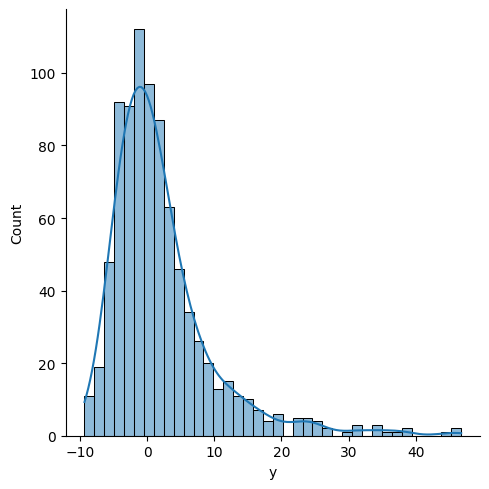

In [19]:
plt.figure(figsize=(10,10))
sns.displot(y_test-y_pred,kde=True)
plt.show()

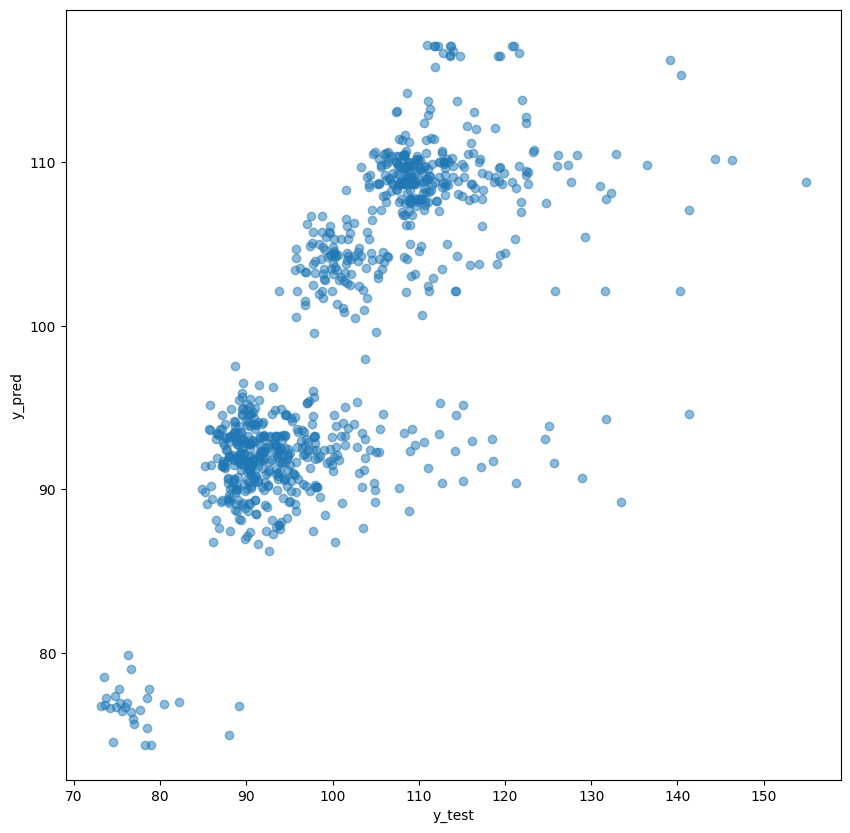

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(y_test,y_pred,alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()